# Convolutioneel Neural Network
*Door: Luuk Bouwman - 1759898*

Klas: V2A

## Voorbereiding

In [1]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, Activation
from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam, schedules
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import utils                              # NumPy gerelateerde tools

## Data Preparation

In [2]:
# Data inladen
cifar10 = tf.keras.datasets.cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print("X_train shape", x_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", x_test.shape)
print("y_test shape", y_test.shape)

X_train shape (50000, 32, 32, 3)
y_train shape (50000, 1)
X_test shape (10000, 32, 32, 3)
y_test shape (10000, 1)


#### Visualize data

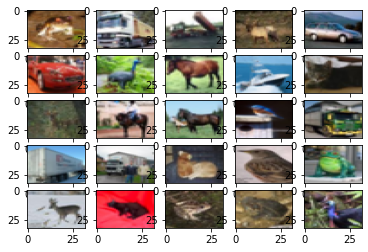

In [3]:
# plot afbeeldingen
fig, ax = plt.subplots(5, 5)
k = 0
 
for i in range(5):
    for j in range(5):
        ax[i][j].imshow(x_train[k], aspect='auto')
        k += 1
 
plt.show()

In [4]:
x_head, *tail = x_train
y_head, *tail = y_train

In [5]:
x_head

array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]

De shape van de data is 32 x 32 x 3. Waarbij de 32 x 32 het aantal pixels aangeeft en de 3 voor de RGB waardes tussen 0 en 255.

In [6]:
y_head

array([6], dtype=uint8)

Zoals je ziet is de target head een getal. Elk getal staat voor een ander dier of vervoersmiddel.
- 0: vliegtuig
- 1: auto
- 2: vogel
- 3: kat
- 4: hert
- 5: hond
- 6: kikker
- 7: paard
- 8: boot
- 9: vrachtwagen

Dus `x_head` zijn alle pixelwaardes (veranderd naar een getal tussen 0 en 1) van een kikker.

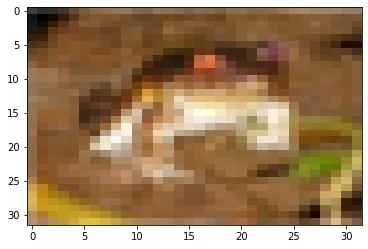

In [7]:
plt.imshow(x_head, aspect='auto')

### Features

In [8]:
# Trainingsdata moet 'flattened' worden

x_train = x_train.reshape(50000, 1024, 3).astype(np.float32) # reshape 50,000 32 x 23 matrices into 50,000 1024-length vectors.
x_test = x_test.reshape(10000, 1024, 3).astype(np.float32)   # reshape 10,000 32 x 32 matrices into 10,000 1024-length vectors.

In [9]:
# Reduce pixel values
x_train, x_test = x_train / 255.0, x_test / 255.0

### Targets

In [10]:
# flatten the label values
y_train, y_test = y_train.flatten(), y_test.flatten()

In [11]:
# number of classes
K = len(set(y_train))

print("number of classes:", K)

y_train = utils.to_categorical(y_train, K)
y_test = utils.to_categorical(y_test, K)

print(f"Y_train: {y_train.shape}, Y_test: {y_test.shape}")

number of classes: 10
Y_train: (50000, 10), Y_test: (10000, 10)


## Baseline model
We starten met een baseline model om een accuracy score te vinden die verbeterd moet worden.

In [ ]:
baseline_model= Sequential()

optimizer = keras.optimizers.Adam(
   learning_rate = 0.01, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False
)
baseline_model.compile(
   optimizer, 
   loss = None, 
   metrics = None, 
   loss_weights = None, 
   sample_weight_mode = None, 
   weighted_metrics = None, 
   target_tensors = None
)
# fit model
history = baseline_model.fit(y_train, y_train, epochs=100, batch_size=64, validation_data=(x_test, y_test), verbose=0)

In [ ]:
# evaluate model
acc = baseline_model.evaluate(x_test, y_test, verbose=0)

In [ ]:
print('> %.3f' % (acc * 100.0))

In [ ]:
baseline_model.add(Dense(512, input_shape=(1024,3))) # (1024,3)
baseline_model.add(Activation("sigmoid"))
baseline_model.add(Dropout(0.2))

baseline_model.add(Dense(512))
baseline_model.add(Activation("sigmoid"))
baseline_model.add(Dropout(0.2))

baseline_model.add(Dense(10))
baseline_model.add(Activation("softmax"))

adam_opt = Adam(learning_rate=0.001)
baseline_model.compile(loss="categorical_crossentropy", optimizer=adam_opt, metrics=["accuracy"])

experiment = baseline_model.fit(x_train, y_train,
               batch_size=128,
               epochs=5,
               verbose=1,
               validation_split = 0.2) 

In [ ]:
# # Fit
# r = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=1)

In [ ]:
# Fit with data augmentation
# Note: if you run this AFTER calling
# the previous model.fit()
# it will CONTINUE training where it left off


# batch_size = 32
# data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
#     width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
 
# train_generator = data_generator.flow(x_train, y_train, batch_size)
# steps_per_epoch = x_train.shape[0] // batch_size
 
# r = model.fit(train_generator, validation_data=(x_test, y_test), steps_per_epoch=steps_per_epoch, epochs=5)